In [1]:
# !pip install transformers

In [2]:
# FOR CUSTOM LOSS FUNCTION
# !pip install -q monai

In [3]:
# !pip install datasets

In [56]:
import matplotlib.pyplot as plt
import numpy as np 
import scipy.io as sio
import cv2
from PIL import Image

In [57]:
# Load the .mat file
mat_data = sio.loadmat('combined_e.mat')

In [58]:
image_slices = mat_data['I']
masks = mat_data['M']

In [59]:
print(image_slices.shape)

(248, 248, 96)


In [60]:
print(masks.shape)

(248, 248, 96)


In [61]:
total_slice=[]
slice_indices = list(range(0, 51))
for slice_index in slice_indices:
    slice_image = image_slices[:, :, slice_index]
    total_slice.append(slice_image)

In [62]:
total_masks=[]
masks_indices = list(range(0, 51))
for slice_index in masks_indices:
    slice_image = masks[:, :, slice_index]
    total_masks.append(slice_image)

In [63]:
len(total_masks)

51

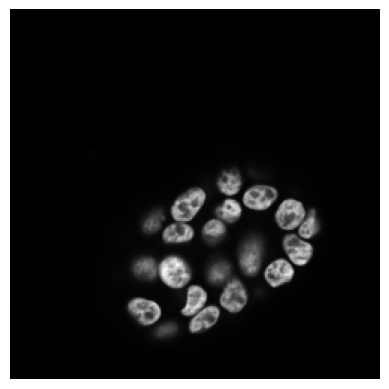

In [64]:
slice_index = 21
slice_image = total_slice[slice_index]
slice_mask = total_masks[slice_index]

# Displaying the image
plt.imshow(slice_image, cmap='gray')
plt.axis('off')
plt.show()

In [65]:
total_masks[0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

(-0.5, 247.5, 247.5, -0.5)

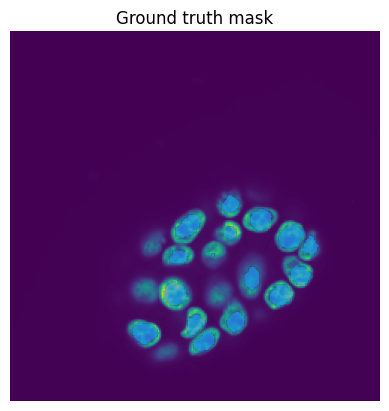

In [66]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(slice_image)
ground_truth_seg = slice_mask
show_mask(ground_truth_seg, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")




(-0.5, 247.5, 247.5, -0.5)

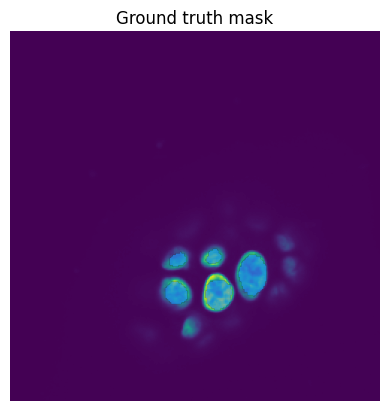

In [67]:
fig, axes = plt.subplots()

axes.imshow(total_slice[11])
ground_truth_seg = total_masks[11]
show_mask(ground_truth_seg, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

(-0.5, 247.5, 247.5, -0.5)

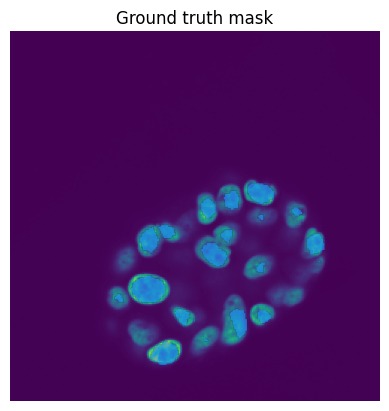

In [68]:
fig, axes = plt.subplots()

axes.imshow(total_slice[30])
ground_truth_seg = total_masks[30]
show_mask(ground_truth_seg, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

In [69]:
len(total_slice)
len(total_masks)

51

In [70]:
total_slices = []

for slice_image in total_slice:
    # Normalize the slice image to the range of 0-255
    normalized_image = cv2.normalize(slice_image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    # Convert grayscale image to 3-channel image
    slice_image_rgb = cv2.cvtColor(normalized_image, cv2.COLOR_GRAY2RGB)

    # Append the converted slice image to the list
    total_slices.append(slice_image_rgb)

# Dataset in model formate

   1: pixel values (which is the image prepared for the model)
   2: a prompt in the form of a bounding box
   3: a ground truth segmentation mask.


## Function to get bounding boxes from the Mask
SAM is trained using certain "prompts", which could be bounding boxes, points, text, or rudimentary masks. 

Model trained using image + prompt

In [170]:
# def get_bounding_box(ground_truth_map):
#   # get bounding box from mask
#   y_indices, x_indices = np.where(ground_truth_map > 0)
#   x_min, x_max = np.min(x_indices), np.max(x_indices)
#   y_min, y_max = np.min(y_indices), np.max(y_indices)
#   # add perturbation to bounding box coordinates
#   H, W = ground_truth_map.shape
#   x_min = max(0, x_min - np.random.randint(0, 20))
#   x_max = min(W, x_max + np.random.randint(0, 20))
#   y_min = max(0, y_min - np.random.randint(0, 20))
#   y_max = min(H, y_max + np.random.randint(0, 20))
#   bbox = [x_min, y_min, x_max, y_max]

#   return bbox

def get_bounding_box(ground_truth_map):
    # Get indices of non-zero elements
    y_indices, x_indices = np.nonzero(ground_truth_map)

    if len(x_indices) == 0 or len(y_indices) == 0:
        # Handle the case when there are no non-zero elements
        bbox = [0, 0, 0, 0]
    else:
        # Compute the bounding box coordinates
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)

        # Add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))

        bbox = [x_min, y_min, x_max, y_max]

    return bbox


In [171]:
# total_masks[21]
a=total_masks[21]
a

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [172]:
get_bounding_box(a)

[72, 99, 223, 228]

In [173]:
total_masks[21].shape

(248, 248)

# save in png images from slices

In [174]:
# from PIL import Image

# # Assuming you have a list of image slices stored in 'image_slices'
# for i, slice in enumerate(total_slice):
#     # Convert the slice to PIL Image format and convert the mode to RGB
#     slice_image = Image.fromarray(slice).convert("RGB")

#     # Save the slice as PNG format
#     slice_image.save(f"slice_{i}.png")

In [175]:
total_masks[21].shape


(248, 248)

In [176]:
total_slice[21].shape


(248, 248)

In [177]:
from torch.utils.data import Dataset, DataLoader

# class SAMDataset(Dataset):
#     def __init__(self, total_masks, total_slices, processor):
#         self.total_masks = total_masks
#         self.total_slices = total_slices
#         self.processor = processor

#     def __len__(self):
#         return len(self.total_slices)

#     def __getitem__(self, idx):
#         im = self.total_slices[idx]
#         image = Image.fromarray(im)
#         ground_truth_mask = self.total_masks[idx]

#         # Ensure ground_truth_mask is binary
#         ground_truth_mask = (ground_truth_mask > 0).astype(np.uint8)

#         # Resize ground_truth_mask to match input tensor shape
#         target_shape = im.shape
#         ground_truth_mask = Image.fromarray(ground_truth_mask)
#         ground_truth_mask = ground_truth_mask.resize(target_shape, resample=Image.BILINEAR)
#         ground_truth_mask = np.array(ground_truth_mask)

#         # Get bounding box prompt
#         prompt = get_bounding_box(ground_truth_mask)

#         # Prepare image and prompt for the model
#         inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

#         # Remove batch dimension which the processor adds by default
#         inputs = {k: v.squeeze(0) for k, v in inputs.items()}

#         # Add ground truth segmentation
#         inputs["ground_truth_mask"] = ground_truth_mask

#         return inputs

class SAMDataset(Dataset):
    def __init__(self, total_masks, total_slices, processor):
        self.total_masks = total_masks
        self.total_slices = total_slices
        self.processor = processor

    def __len__(self):
        return len(self.total_slices)

    def __getitem__(self, idx):
        im = self.total_slices[idx]
        image = Image.fromarray(im)
        ground_truth_mask = self.total_masks[idx]

        # Resize ground_truth_mask to (256, 256)
        ground_truth_mask = Image.fromarray(ground_truth_mask)
        ground_truth_mask = ground_truth_mask.resize((256, 256), resample=Image.BILINEAR)
        # ground_truth_mask = resize(ground_truth_mask, (256, 256), order=1, mode='reflect')
        ground_truth_mask = np.array(ground_truth_mask)

        # Ensure ground_truth_mask is binary
        ground_truth_mask = (ground_truth_mask > 0).astype(np.uint8)

        # Get bounding box prompt
        prompt = get_bounding_box(ground_truth_mask)

        # Prepare image and prompt for the model
        inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

        # Remove batch dimension which the processor adds by default
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}

        # Add ground truth segmentation
        inputs["ground_truth_mask"] = ground_truth_mask

        return inputs



# class SAMDataset(Dataset):
#     def __init__(self, total_masks, total_slices, processor):
#         self.total_masks = total_masks
#         self.total_slices = total_slices
#         self.processor = processor

#     def __len__(self):
#         return len(self.total_slices)

#     def __getitem__(self, idx):
#         im = self.total_slices[idx]
#         image = Image.fromarray(im)
#         ground_truth_mask = self.total_masks[idx]

#         # Ensure ground_truth_mask is non-empty and contains valid mask values
#         if np.any(ground_truth_mask):
#             # Resize ground_truth_mask to (256, 256)
#             ground_truth_mask = Image.fromarray(ground_truth_mask)
#             ground_truth_mask = ground_truth_mask.resize((256, 256), resample=Image.BILINEAR)
#             ground_truth_mask = np.array(ground_truth_mask)

#             # Ensure ground_truth_mask is binary
#             ground_truth_mask = (ground_truth_mask > 0).astype(np.uint8)
#         else:
#             # Handle empty mask case
#             ground_truth_mask = np.zeros((256, 256), dtype=np.uint8)

#         # Get bounding box prompt
#         prompt = get_bounding_box(ground_truth_mask)

#         # Prepare image and prompt for the model
#         inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

#         # Remove batch dimension which the processor adds by default
#         inputs = {k: v.squeeze(0) for k, v in inputs.items()}

#         # Add ground truth segmentation
#         inputs["ground_truth_mask"] = ground_truth_mask

#         return inputs


In [178]:
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [179]:
# Create an instance of your custom dataset
train_dataset = SAMDataset(total_masks, total_slice, processor)

In [180]:
example = train_dataset[21]
for k,v in example.items():
  print(k,v.shape)


pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


## PyTorch Dataloader,allows to get batches from oUR dataset.

In [181]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
#2 samples LOAD from the dataset RANDOMY.

In [182]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)


pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


___________________________________________________________ 
                                                          

                  Step 1: Load Pre-trained Model           

___________________________________________________________
       /\ 

       || 

       \/ 

     SAM Model 
_________________________________________________________ 

                                                        

            Step 2: Freeze Specific Model Layers        
_________________________________________________________

       /\ 

       || 

       \/ 

     SAM Model 
_________________________________________________________ 
                                                        

                Step 3: Define Optimizer                
_________________________________________________________

       /\ 

       || 

       \/ 

     SAM Model 
_________________________________________________________ 
                                                         
             Step 4: Define Segmentation Loss           

_________________________________________________________

       /\ 

       ||    seg_loss = monai.losses.DiceCELoss

       \/ 

     SAM Model 
_______________________________________________________ 

                                                         

                Step 5: Training Loop                  

_________________________________________________________

       /\ 

       || Accuracy Measure/Loss Curve

       \/ 

     SAM Model 

# lOAD Model

In [183]:
from transformers import SamModel 

model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)
    
#freez the layer--> Set requires_grad to False for those parameters to freeze them, preventing them from being updated during fine-tuning.

# Trainig Model

In [184]:
from torch.optim import Adam
import monai

# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [185]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize
import time

num_epochs = 10
mean_losses = []
all_epoch_time=[]
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    
    start_time = time.time()  # Start time for the epoch
    
    for batch in tqdm(train_dataloader):
        # forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        # compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        # backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        loss.backward()

        # optimize
        optimizer.step()
        epoch_losses.append(loss.item())

    end_time = time.time()  # End time for the epoch
    epoch_time = end_time - start_time  # Calculate the time taken for the epoch
    
    mean_losses.append(mean(epoch_losses))
    all_epoch_time.append(epoch_time)
    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')
    print(f'Training time for the epoch: {epoch_time} seconds')


100%|██████████| 26/26 [00:11<00:00,  2.26it/s]


EPOCH: 0
Mean loss: 0.4726401624771265
Training time for the epoch: 11.496034622192383 seconds


100%|██████████| 26/26 [00:11<00:00,  2.28it/s]


EPOCH: 1
Mean loss: 0.3764108854990739
Training time for the epoch: 11.391730546951294 seconds


100%|██████████| 26/26 [00:11<00:00,  2.28it/s]


EPOCH: 2
Mean loss: 0.3218249174264761
Training time for the epoch: 11.398432493209839 seconds


100%|██████████| 26/26 [00:11<00:00,  2.26it/s]


EPOCH: 3
Mean loss: 0.29233982929816615
Training time for the epoch: 11.498542070388794 seconds


100%|██████████| 26/26 [00:11<00:00,  2.27it/s]


EPOCH: 4
Mean loss: 0.21770056394430307
Training time for the epoch: 11.435739278793335 seconds


100%|██████████| 26/26 [00:11<00:00,  2.27it/s]


EPOCH: 5
Mean loss: 0.18900107649656442
Training time for the epoch: 11.445566415786743 seconds


100%|██████████| 26/26 [00:11<00:00,  2.27it/s]


EPOCH: 6
Mean loss: 0.18420328772985017
Training time for the epoch: 11.436835289001465 seconds


100%|██████████| 26/26 [00:11<00:00,  2.27it/s]


EPOCH: 7
Mean loss: 0.1818533562696897
Training time for the epoch: 11.442960739135742 seconds


100%|██████████| 26/26 [00:11<00:00,  2.26it/s]


EPOCH: 8
Mean loss: 0.1697889738357984
Training time for the epoch: 11.50178050994873 seconds


100%|██████████| 26/26 [00:11<00:00,  2.26it/s]

EPOCH: 9
Mean loss: 0.1665697178015342
Training time for the epoch: 11.524263858795166 seconds


## Inferance: using a trained model to make predictions on unseen or new data. 

### Get the data from our dataset 

In [254]:
image = Image.fromarray(total_slices[21])

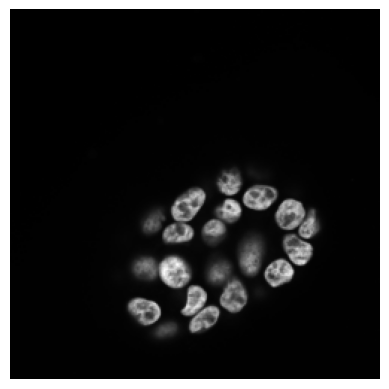

In [277]:
import numpy as np
from PIL import Image

# load image
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

In [293]:
ground_truth_mask = total_masks[21]
prompt = get_bounding_box(ground_truth_mask)


In [294]:
# prepare image + box prompt for the model
inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)
for k,v in inputs.items():
  print(k,v.shape)

pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])


## Passing input to the trained model 

In [295]:
#This is typically done before performing inference/Testing the our trained model
model.eval()
model.to(device)  # Move the model's parameters to the same device as the input tensors

# forward pass
with torch.no_grad():
  inputs = {k: v.to(device) for k, v in inputs.items()}  # Move the input tensors to the same device as the model
  outputs = model(**inputs, multimask_output=False)

In [296]:
# Its necessary to apply sigmoid function to the predicted masks -->so that predicted mask between 0 and 1
# apply sigmoid
predicted_mask_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
predicted_mask_prob = predicted_mask_prob.cpu().numpy().squeeze()
predicted_mask = (predicted_mask_prob > 0.5).astype(np.uint8)

# threshold of 0.5 is applied to the medsam_seg_prob array to convert the soft masks into hard masks. 
#Any pixel value greater than 0.5 is considered as belonging to the target class, while values less than or equal to 0.5 are considered as background. 
#The resulting hard mask medsam_seg is represented as a numpy array of unsigned integers (np.uint8), where background pixels are encoded as 0 and target class pixels as 1.
#
#
#
# The purpose of converting the soft masks to hard masks is to obtain a binary segmentation result where each pixel is classified as either belonging to the target class or not.

In [297]:
predicted_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

## Show predicted Mask

(-0.5, 255.5, 255.5, -0.5)

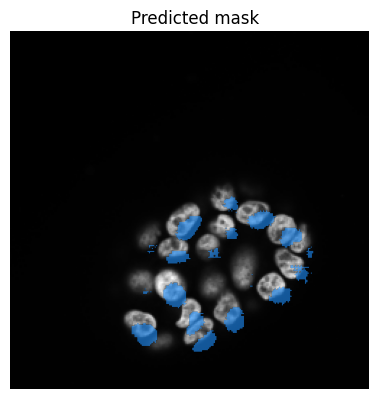

In [298]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(np.array(image))
show_mask(predicted_mask, axes)
axes.title.set_text(f"Predicted mask")
axes.axis("off")

# Compare it to ground truth segmentation:

(-0.5, 247.5, 247.5, -0.5)

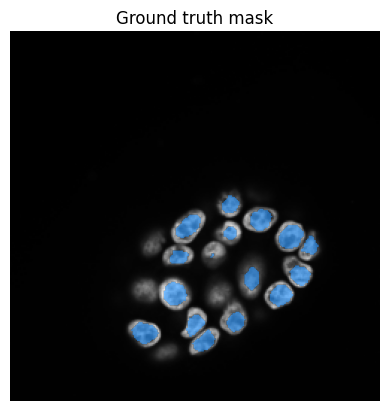

In [299]:
fig, axes = plt.subplots()

axes.imshow(np.array(image))
show_mask(ground_truth_mask, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

In [303]:
predicted_mask.shape

(256, 256)

In [307]:
import numpy as np
from scipy import ndimage

In [308]:
ground_truth_mask.shape

(248, 248)

In [309]:
ground_truth_mask = ndimage.zoom(ground_truth_mask, (256 / 248, 256 / 248), order=1)

In [310]:
def calculate_pixel_accuracy(predicted_mask, ground_truth_mask):
    correct_pixels = np.sum(predicted_mask == ground_truth_mask)
    total_pixels = predicted_mask.size
    pixel_accuracy = correct_pixels / total_pixels
    return pixel_accuracy


In [311]:
pixel_accuracy = calculate_pixel_accuracy(predicted_mask, ground_truth_mask)


In [312]:
print("pixel_accuracy:",pixel_accuracy)

pixel_accuracy: 0.986328125


Pixel Accuracy: Pixel accuracy is a metric that measures the percentage of correctly classified pixels in the predicted mask compared to the ground truth mask. It is calculated by dividing the number of correctly classified pixels by the total number of pixels and multiplying by 100 to get a percentage. A pixel accuracy of 98.1308% indicates a high level of accuracy in pixel-level classification, with a large majority of pixels being correctly classified.

In [313]:
def calculate_iou(predicted_mask, ground_truth_mask):
    intersection = np.logical_and(predicted_mask, ground_truth_mask).sum()
    union = np.logical_or(predicted_mask, ground_truth_mask).sum()
    iou = intersection / union
    return iou


In [314]:
iou = calculate_iou(predicted_mask, ground_truth_mask)


In [315]:
print("iou:",iou)
#ntersection over Union = Intersection / (Prediction + Ground Truth -Intersection)

iou: 0.6535189481825213


IOU (Jaccard Index): The IOU (Intersection over Union) or Jaccard Index is another metric that measures the overlap between the predicted mask and the ground truth mask. It is calculated by dividing the area of intersection between the two masks by the area of their union. The IOU ranges from 0 to 1, with 1 indicating a perfect match. A value of 0.8312 suggests a substantial overlap between the predicted and ground truth masks.

In [316]:
def calculate_dice_score(predicted_mask, ground_truth_mask):
    intersection = np.logical_and(predicted_mask, ground_truth_mask).sum()
    dice_score = 2.0 * intersection / (predicted_mask.sum() + ground_truth_mask.sum())
    return dice_score


In [317]:
dice_score = calculate_dice_score(predicted_mask, ground_truth_mask)
#

In [318]:
print("dice_score:",dice_score)


dice_score: 0.7904583723105706


Dice Score: The Dice score, also known as the F1 score, is a measure of the overlap between the predicted mask and the ground truth mask. It ranges from 0 to 1, with 1 indicating a perfect match between the two masks. A Dice score of 0.9078 indicates a high level of similarity between the predicted mask and the ground truth mask, suggesting that the model performs well in capturing the target object.

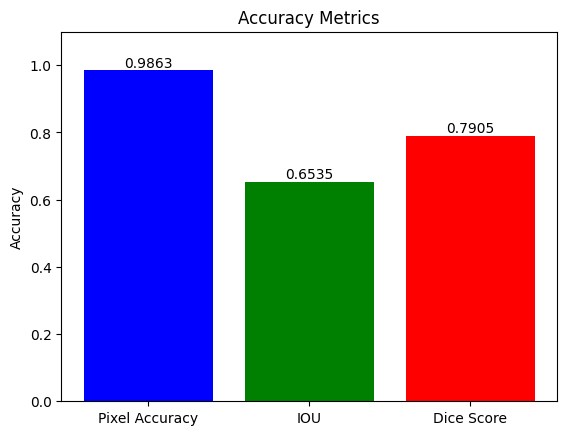

In [319]:
# Create a bar plot
metrics = ['Pixel Accuracy', 'IOU', 'Dice Score']
values = [pixel_accuracy, iou, dice_score]
colors = ['blue', 'green', 'red']

plt.bar(metrics, values, color=colors)
plt.ylabel('Accuracy')
plt.ylim(0, 1.1)  # Set the y-axis limits to 110
plt.title('Accuracy Metrics')

# Add scores on top of each bar
for i, v in enumerate(values):
    plt.text(i, v, f'{v:.4f}', ha='center', va='bottom')
plt.show()


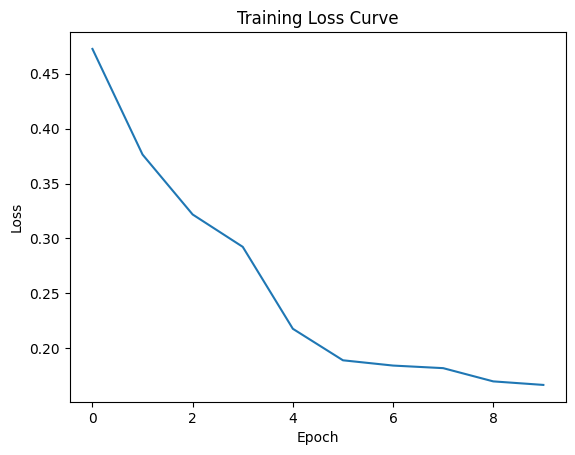

In [320]:
plt.plot(mean_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()


Loss Curve: Plot the training loss over epochs to visualize the training progress and convergence of your model.The best training Loss Curve is typically one that shows a decreasing trend over the epochs. This indicates that the model is learning and minimizing the loss function with each iteration.

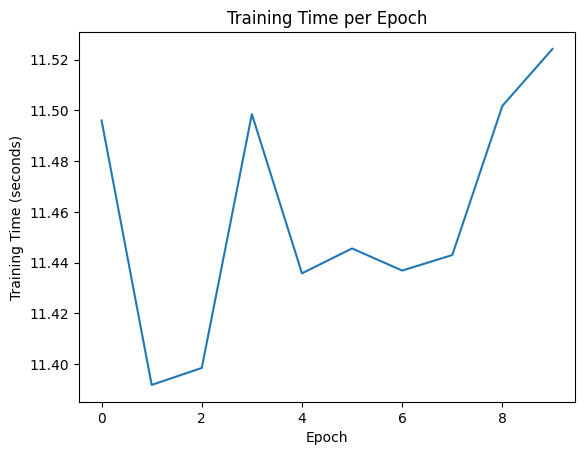

In [321]:
plt.plot(all_epoch_time)
plt.xlabel('Epoch')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time per Epoch')
plt.show()


Resource Management: Training time per epoch provides insights into the computational resources required for training your model. It helps estimate the time and resources needed to train the model on larger datasets or more complex SAM architectures. This information is valuable for resource planning and optimizing the training process.

Scalable: The training time per epoch should scale well with increasing dataset sizes or model complexities. As the dataset or model size grows, the training time should increase proportionally, but not excessively. This ensures that the training process remains feasible and time-efficient as the complexity of the problem increases.